In [ ]:
import math
import cv2 as cv
import cupy as cp
import numpy as np

import matplotlib.pyplot as plt

## CUDA Convolution

In [ ]:
def kernels_shapes(N, kernel):
    """calculates the kernel shape used for sliding_window_view function and the total elements
    of the kernel used for reshaping function

    Args:
        N (tuple): the shape tuple of the image
        kernel (np.ndarray): the kernel(s) to calculate the required shapes

    Returns:
        tuple: the tuple shape for using in sliding_window_view
        total: the calculation of the total items in the kernel(s)
    """
    k = kernel.shape
    n = len(N) - len(k)
    return k + tuple([1] * n), np.prod(np.asarray(k))

def apply_2d_filter(image, kernels=(), padding=1):
    """Shapes the image into sliding windows and that result into a transposed matrix where rows
    are the contents of each window and columns are the windows calculated from the sliding_window_view.
    A matrix multiplication is performed for calculating the convolutions.

    Args:
        image (np.ndarray): the image to calculate the operator
        kernels (tuple, optional): the kernel(s) to operate on the image. Defaults to ().
        padding (int, optional): size of the borders added to the image. Defaults to 1.

    Returns:
        np.ndarray: A tensor with the images one per kernel (img, H, W)
    """
    assert image is not None, "Image must not be None"
    assert len(kernels) > 0, "Must be at least one kernel"
    assert all(len(i) == len(kernels[0]) for i in kernels), "Kernels must be of the same size"

    k, kdim = kernels_shapes(image.shape, kernels[0])

    xp = cp.get_array_module(image)

    # Adds a pad to the borders of each image
    img = xp.pad(image.astype(xp.float32), pad_width=(padding,padding))

    # Shapes the kernels in a single matrix
    kernels = [ xp.reshape(kl, kdim) for kl in kernels ]
    kstack = xp.vstack(kernels).astype(xp.float32)

    # Creates the sliding windows from the image with k size
    views = xp.lib.stride_tricks.sliding_window_view(img, k)
    N = views.shape

    # reshape the view to form a matrix
    stack = xp.reshape(views, (N[0] * N[1], kdim)).T

    # perform the matrix multiplication
    map = kstack @ stack

    # convert back the image from flatten to 2 dims
    res = xp.reshape(map, (map.shape[0], N[0], N[1]))

    return res

In [ ]:
def prewitt(img, padding=1):
    xp = cp.get_array_module(img)

    kernel1 = xp.asarray([[1,0,-1],[1,0,-1],[1,0,-1]])
    kernel2 = xp.asarray([[1,1,1],[0,0,0],[-1,-1,-1]])

    flt = apply_2d_filter(img, kernels=(kernel1, kernel2), padding=padding)

    res1, res2 = xp.vsplit(flt,2)

    res = xp.sqrt(xp.square(xp.squeeze(res1)) + xp.square(xp.squeeze(res2)))

    return res.astype(xp.int32)

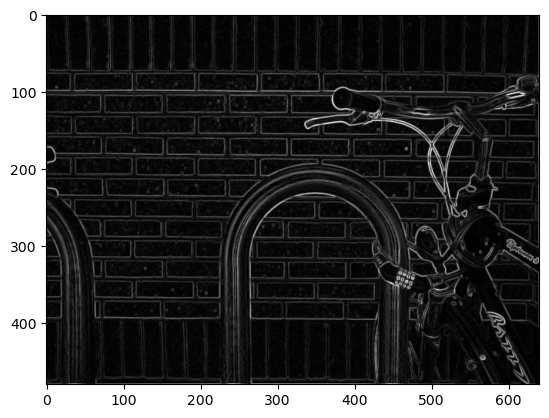

In [ ]:
img = cv.imread('../datasets/Bikesgray.jpg', cv.IMREAD_GRAYSCALE)
img = cp.asarray(img)

res = prewitt(img)
res = cp.asnumpy(res)

plt.imshow(res, cmap='gray')

## Comparison

In [ ]:
# Read the image
img = cv.imread('../datasets/mountain.jpg', cv.IMREAD_GRAYSCALE)

In [ ]:
# transfer img to device and host
cuda = cp.asarray(img)
cpu = np.asarray(img)

In [ ]:
%%timeit
prewitt(cpu)

97.8 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
prewitt(cuda)

2.6 ms ± 21.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
